# Login

In [2]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import qulab
from qulab.tools.wavedata import *

In [ ]:
#print(qulab.admin.get_database())
#qulab.admin.get_collection_info()
#qulab.admin.drop_collection(database='ten_qubits_measurement',
#                            collection=['application',])
qulab.admin.set_database('qubit_measurement')

In [ ]:
#qulab.admin.register()

In [ ]:
qulab.login('liuqichun','123456')

# data process

## 3D spectrum

In [ ]:
qulab.query('auto_meas.three_dim_spectroscopy').display()

In [ ]:
fig = plt.figure()
f_sweet = 4.152
bias_period = 650
bias_center = 143

#record = qulab.query('auto_meas.three_dim_spectroscopy')[0]
# 绘制三维能谱图
x, y, amp = record.data
amp = np.array(amp).T
amp[amp<0] = 0.6
ax = fig.add_subplot(121)
a = ax.imshow(amp[0], extent=((min(y)*1000-bias_center)/bias_period, 
                              (max(y)*1000-bias_center)/bias_period, 
                              min(x)/1e9, max(x)/1e9),
              aspect='auto', origin='lower', interpolation='nearest')
ax.set_ylabel('freq(GHz)')
ax.set_xlabel('bias(phi_0)')
ax.set_title('Q10_spectrum_sweep_bias',fontsize=15)

# 计算qubit频率随bias的变化
bias_list = np.linspace(-0.06,0.06,25)
freq_list = f_sweet*(np.cos(bias_list*np.pi)+1.0)/2.0
ax.plot(bias_list,freq_list,'b-')
ax.plot([-0.032,],[f_sweet*(np.cos(-0.032*np.pi)+1.0)/2.0,],'r<')
ax.text(0,4.13,'working point:',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(0,4.125,'bias: 0.0387',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(0,4.12,'freq: 4.142GHz',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")

# 计算d_f/d_b
ax1 = fig.add_subplot(122)
d_freq_list = -f_sweet*np.sin(bias_list*np.pi)/2.0
ax1.plot(bias_list,d_freq_list,'b-')
ax1.plot([-0.032,],[-f_sweet*np.sin(-0.032*np.pi)/2.0,],'r<')
ax1.set_title('Q10_delta_f/delta_bias',fontsize=15)
ax1.text(0,0.4,'working point:',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax1.text(0,0.3,'bias: -0.035',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax1.text(0,0.2,'d_f/d_b: '+str(round(-f_sweet*np.sin(-0.032*np.pi)/2.0,5)),fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")

## RBM line

In [ ]:
qulab.query('auto_meas.rbm_line').display()

In [ ]:
from qulab.tools.datafit import *
from qulab.tools.fileprocess._fileprocess import *

# get record result
record = qulab.query('auto_meas.rbm_line')[3]
# save record result to txt file and plot
path = os.path.join('E:/qubit_measurent_20200108/meas_result','RBM_line','Q9_reference_line.txt')
record2txt(record=record, txt_path=path, png=True, fig_title='Q9_reference_line')

ax = plt.gca()
fit = RBM_Fit((record.data[0],record.data[1]), d=2, p0=[1,0.5,0.99])
fit.plot()

ax.set_title('Q9_reference_line',fontsize=25)
ax.set_xlabel('Cliffords num')
ax.set_ylabel('Fidelity')
ax.text(100,0.9,'p_ref='+str(round(fit.p,4))
        +'$_{%.4f}^{%.4f}$'%(fit.p_error,fit.p_error),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(100,0.85,'F_ref='+str(round(1-(1-fit.F)/1.875,4))
        +'$_{%.4f}^{%.4f}$'%(fit.F_error/1.875,fit.F_error/1.875),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

In [ ]:
from qulab.tools.datafit import *
from qulab.tools.fileprocess._fileprocess import *

p_ref = 0.9891
# get record result
record = qulab.query('auto_meas.rbm_line')[4]
# save record result to txt file and plot
path = os.path.join('E:/qubit_measurent_20200108/meas_result','RBM_line','Q9_X_gate_line.txt')
record2txt(record=record, txt_path=path, png=True, fig_title='Q9_X_gate_line')

ax = plt.gca()
fit = RBM_Fit((record.data[0],record.data[1]), d=2, p0=[0.5,0.5,0.99])
fit.plot()

ax.set_title('Q9_X_gate_line',fontsize=25)
ax.set_xlabel('Cliffords num')
ax.set_ylabel('Fidelity')
ax.text(150,0.9,'p_X='+str(round(fit.p,4))
        +'$_{%.4f}^{%.4f}$'%(fit.p_error,fit.p_error),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(150,0.85,'Fidelity_X='+str(round((1+fit.p/p_ref)/2,4))
        +'$_{%.4f}^{%.4f}$'%(fit.F_error,fit.F_error),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

## RTO line

In [ ]:
from qulab.tools.datafit import *
from scipy.fftpack import fft,ifft
sRate = 100/(11*36)

# 取原始数据
#data=qulab.query('auto_meas.rto_line')[1].data
# 修正采集卡产生的错误数据
data_p = np.array(data[1])
data_p[data_p<0] = 835000
# 去除测试设置的偏置频率，并做单位转化
data_p = (data_p-np.mean(data_p))/1e6 #原始数据单位为 Hz

# 做fft
fft_data = fft(data_p)/len(data_p)
# 获取能量谱PSD
index = int((len(fft_data)+1)/2)
# 获取和fft_data对应的真实频谱频率
x_1 = np.array([n for n in range(index)])
if len(fft_data)%2==0:
    x_2 = np.array([n for n in range(index)])+1
    x_2 = -x_2[::-1]
else:
    x_2 = np.array([n for n in range(index-1)])+1
    x_2 = -x_2[::-1]
freq = np.append(x_1,x_2)*sRate/len(data_p)
# 滑动窗口平滑
freq = freq[15:4985]
fft_data_p = np.convolve(abs(fft_data[1:5000]), np.ones((30,))/30, mode='valid')


# 转化为磁通的噪声谱
freq_bias_ratio = -0.28504*1000 #乘以1000是转为 MHz 单位
bias_noise = 1e12*fft_data_p/(freq_bias_ratio*freq_bias_ratio)


# 进行拟合
class RTO_Fit(BaseFit):
    '''Simple Linear Fit'''
    def _fitfunc(self,t,alpha,A,B):
        y= A/t**alpha + B
        return y
    @property
    def alpha(self):
        alpha,A,B=self._popt
        return alpha
    @property
    def A(self):
        alpha,A,B=self._popt
        return A
    @property
    def B(self):
        alpha,A,B=self._popt
        return B
# 拟合
fit = RTO_Fit((freq,bias_noise),p0=[1,10,3000])

# 画图
fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq,bias_noise,'b-')
fit.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Noise PSD ($\mu\phi_{0}^{2}/Hz$)')
ax.set_xlabel('Frequency(Hz)')
ax.set_title('RTO noise psd line',fontsize=20)

ax.text(2e-2,2.5e4,'1/f noise magnitude '+'$S^{*}$='+str(round(fit.A,4)),
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(2e-2,2.0e4,'1/f noise slope '+'a='+str(round(fit.alpha,4)),
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(2e-2,1.5e4,'white noise = '+str(round(fit.B,4)),
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

ax.text(1e-3,4e3,'$\mathrm{S=A/f^a+B}$',
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

## data fit

<IPython.core.display.Javascript object>


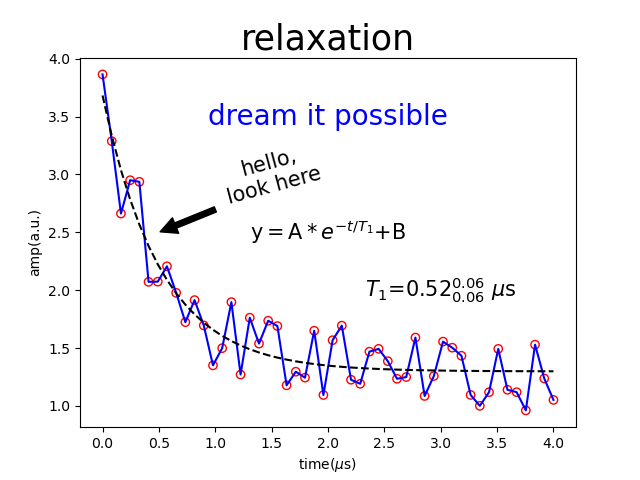

c:\users\lqc\appdata\local\programs\python\python37\lib\site-packages\qulab\tools\datafit\_Fit.py:32: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(t, y, **scatter_kw)


Text(2, 2.5, '$\\mathrm{y=A*}$$e^{-t/T_1}$$\\mathrm{+B}$')

In [4]:
from qulab.tools.datafit import *

def func(t, A, B, T1):
    '''this an example: T1 fit function '''
    y=A*np.exp(-t/T1)+B
    return y
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(72)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xdata, ydata, 'b-', label='data')

fit = T1_Fit((xdata,ydata))
fit.plot()

ax.set_title('relaxation',fontsize=25)
ax.set_xlabel('time($\mu$s)')
ax.set_ylabel('amp(a.u.)')

ax.annotate('hello,'+'\n'+'look here', xy=(0.5, 2.5), xytext=(1.5, 3), 
            fontsize=15,rotation=15,
            verticalalignment="center",
            horizontalalignment="center",
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.text(2,3.5,'dream it possible',fontsize=20, color='b',
        verticalalignment="center",
        horizontalalignment="center")

ax.text(3,2,'$T_1$='+str(round(fit.T1,2))
        +'$_{%.2f}^{%.2f}$'%(fit.T1_error,fit.T1_error)
        +' $\mu$'+'s',fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

ax.text(2,2.5,'$\mathrm{y=A*}$'+'$e^{-t/T_1}$'+'$\mathrm{+B}$',
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

## modified by transfer_func H(w)

<IPython.core.display.Javascript object>


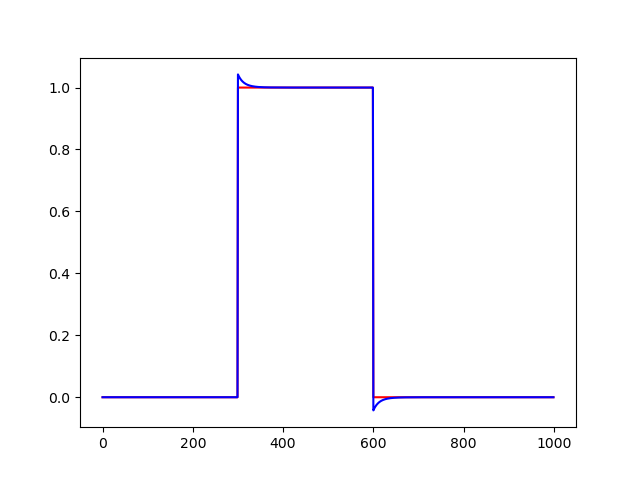

c:\users\lqc\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
import numpy as np
from qulab.tools.wavedata import *

pulse = Blank(width=300e-9,sRate=1e9)|DC(width=300e-9,sRate=1e9)
pulse = Wavedata.setLen(pulse,1e-6)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(pulse.data,'r')

transfer_func = lambda w: 1+1j*0.02*w/(1j*w+1e9/10)+1j*0.014*w/(1j*w+1e9/15)+1j*0.01*w/(1j*w+1e9/20)
pulse = pulse.transfer_wd(transfer_func)
ax1.plot(pulse.data,'b')

# record file process

## Data acquire

In [ ]:
## 数据获取
qulab.query('PNA.three_dim_S21_sweep_mag_bias').display()
print(qulab.query('PNA.three_dim_S21_sweep_mag_bias').count())

In [ ]:
## 数据删除
from qulab.tools.fileprocess import *
del_record(fullname='Rabi.rabi_line',index=[i for i in range(0)])

In [ ]:
## 查看数据库的集合
qulab.admin.get_collection_info(database='qulab')

In [ ]:
## 删除数据库的集合
#qulab.admin.drop_collection(database='qulab', collection=['driver','instrument',])

## data save

In [ ]:
## record存储为txt文件，同时保存图片
from qulab.tools.fileprocess import *
#print(qulab.query('PNA.three_dim_S21_sweep_mag_bias').display())
record2txt(record=qulab.query('PNA.three_dim_S21_sweep_mag_bias')[6], 
           txt_path='/Users/liuqichun/Desktop/3D_S21_sweep_bias.txt', 
           tag='for test', png=True)
record2txt(record=qulab.query('PNA.S21')[38], 
           txt_path='/Users/liuqichun/Desktop/S21.txt', 
           tag='for test', png=True)

In [ ]:
## 数据存储为‘.npz'文件
from qulab.tools.fileprocess._fileprocess import *
data = qulab.query('Rabi.three_dim_rabi')[9].data
tag = get_record_info(qulab.query('Rabi.three_dim_rabi')[9])
save(path='/Users/liuqichun/Desktop',
     name='for_test',
     x=data[0],
     y=data[1],
     z=data[2],1
     tag=tag)
save(name='for_test',
     x=data[0],
     y=data[1],
     z=data[2],
     tag=tag)
save(path='/Users/liuqichun/Desktop',
     name='for_test1.npz',
     record=qulab.query('Rabi.three_dim_rabi')[9])

In [ ]:
## 读取’.npz‘文件绘图
dataout=np.load('tempdata/20190725/for_test.npz')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dataout['z'], extent=(min(dataout['x'])*1e9, max(dataout['x'])*1e9, 
                                min(dataout['y']), max(dataout['y'])),
          aspect='auto', origin='lower', interpolation='nearest')
ax.set_xlabel('time (ns)')
ax.set_ylabel('power (dBm)')

In [ ]:
# 绘制三维图
from mpl_toolkits.mplot3d import Axes3D
freq, bias, amp, phase = qulab.query('PNA.three_dim_S21_sweep_mag_bias')[6].data
freq = np.tile(freq, (len(bias),1))
bias = np.tile(bias, (len(freq[0]),1)).T

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(bias*1e3,freq/1e9,amp,rstride=1, cstride=1, cmap='rainbow')
ax1.set_xlabel('bias current (mA)')
ax1.set_ylabel('frequency (GHz)')
ax1.set_zlabel('amplitude (dB)')
ax2.plot_surface(bias*1e3,freq/1e9,phase,rstride=1, cstride=1, cmap='rainbow')
ax2.set_xlabel('bias current (mA)')
ax2.set_ylabel('frequency (GHz)')
ax2.set_zlabel('phase (degree)')

# examples still need debug

## x6 example

In [ ]:
x6 = qulab.open_resource('X6')

In [ ]:
config=dict(ref_clk_source = 'INTERNAL',
                           sample_clk_source = 'INTERNAL',
                           trig_source = 'MUNUAL',
                           adc_inchannel = [1,1],
                           n=2048,
                           repeats=40,
                           sampleRate=1e9,
                           dac_outchannel = [1,1,1,1],
                           dac_sRate=0.5e9)
x6.set_para(**config)
x6.trig_n = 100

In [ ]:
x6.get_temperature()

In [ ]:
from qulab.tools.wavedata import *
pulse = Blank(width=20e-9,sRate=0.5e9)|CosPulse(width=0.2e-6,sRate=0.5e9)|DC(width=0.2e-6,sRate=0.5e9)*-1
pulse = Wavedata.setLen(pulse,8000e-9)
wavedata = np.hstack(np.array([pulse.data,pulse.data,pulse.data,pulse.data]).T)

In [ ]:
x6.write_dac_wavedata(wavedata)

In [ ]:
ch_A,ch_B = x6.acquire_adc_data()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.mean(ch_A[2:,:],axis=0),'r-*')
ax.plot(np.mean(ch_B[2:,:],axis=0),'b-<')